In [3]:

import pandas as pd
import threading
import concurrent.futures as futures
from sklearn.linear_model import LogisticRegression
from scoring import incr_act_top10
from sklearn.neural_network import MLPClassifier
seed = 1
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import random

from xgboost.sklearn import XGBClassifier, XGBRegressor
from causalml.inference.meta import BaseTClassifier
from causalml.inference.meta import BaseSClassifier
from causalml.inference.meta import BaseXClassifier,BaseRClassifier
from causalml.dataset import make_uplift_classification
from sklearn.model_selection import train_test_split

from causalml.inference.meta import BaseTLearner
from causalml.inference.meta import BaseSLearner
from causalml.inference.meta import BaseXLearner
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error as mse
from scipy.stats import entropy
import warnings

from causalml.inference.meta import LRSRegressor
from causalml.inference.meta import XGBTRegressor, MLPTRegressor
from causalml.inference.meta import BaseXRegressor, BaseRRegressor, BaseSRegressor, BaseTRegressor
from causalml.match import NearestNeighborMatch, MatchOptimizer, create_table_one
from causalml.propensity import ElasticNetPropensityModel
from causalml.dataset.regression import *
from causalml.metrics import *
from imblearn.over_sampling import SMOTE
from matplotlib import pyplot as plt

import os, sys

from scoring import incr_act_top10

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
Failed to import duecredit due to No module named 'duecredit'


In [4]:
# all data
df = pd.read_csv('../../raw_data/training_set.csv')


In [4]:
train_set, validation_set = train_test_split(df, test_size=0.2, stratify=df[['ind_recommended', 'activation']], random_state=seed)


In [5]:
train_set.fillna(0.0, inplace=True)
validation_set.fillna(0.0, inplace=True)

In [6]:
# Move 'distance_05' column to the first position for train_set_recommended
if('distance_05' in train_set.columns):
    col = train_set.pop('distance_05')
    train_set.insert(0, col.name, col)

train_set_recommended = train_set[train_set['ind_recommended'] == 1].drop(columns=['customer', 'merchant'],axis=1,inplace=False)
train_set_not_recommended = train_set[train_set['ind_recommended'] == 0].drop(columns=[ 'customer', 'merchant'],axis=1,inplace=False)

assert not train_set_recommended.isna().values.any()
assert not train_set_not_recommended.isna().values.any()

In [7]:
def balance_classes_with_smote(df, class_column, sample_size, seed, k_neighbors=5):
    smote = SMOTE(sampling_strategy='auto', k_neighbors=k_neighbors)

    # Sample rows where activation is 0 and where activation is 1
    filtered_non_activation = df[df[class_column] == 0].sample(n=sample_size, random_state=seed)
    filtered_activation = df[df[class_column] == 1]

    # Concatenate the filtered dataframes
    df_balanced = pd.concat([filtered_non_activation, filtered_activation], axis=0)

    # Apply SMOTE to the activation data
    X_resampled, y_resampled = smote.fit_resample(df_balanced.drop([class_column], axis=1), df_balanced[class_column])

    # Combine the resampled data
    df_resampled = pd.DataFrame(X_resampled, columns=df_balanced.drop([class_column], axis=1).columns)
    df_resampled[class_column] = y_resampled

    return df_resampled

def balance_classes(df, class_column, sample_size, seed):
    filtered_non_activation = df[df[class_column] == 0].sample(n=sample_size, random_state=seed)
    filtered_activation = df[df[class_column] == 1].sample(n=sample_size, random_state=seed)

    return pd.concat([filtered_non_activation, filtered_activation], axis=0)


# Apply balance_classes_with_smote function to train_set_recommended
train_set_recommended = balance_classes_with_smote(train_set_recommended, 'activation', 30000, seed)

# Apply balance_classes_with_smote function to train_set_not_recommended
train_set_not_recommended = balance_classes(train_set_not_recommended, 'activation', 30000, seed)

In [8]:
train_total = pd.concat([train_set_recommended,train_set_not_recommended],axis=0).sample(frac=1,random_state=seed)

In [9]:
def draw(df,learner,name):
    x_val = df.drop(columns=['customer', 'merchant','ind_recommended','activation'],axis=1,errors='ignore')

    x_pred = learner.predict(x_val)
    df_preds = pd.DataFrame([x_pred.ravel(),
                            df['ind_recommended'].ravel(),
                            df['activation'].ravel()],
                        index=[name,'w','y']).T

    print("head\n",df_preds.sort_values(by=[name],ascending=False).head(15))
    print("Auuc\n",auuc_score(df_preds))
    fig,ax = plt.subplots()
    ax.hist(df_preds)

    # Customizing the plot
    ax.set_title(name)
    ax.set_xlabel('Score')
    ax.set_ylabel('Frequency')
    ax.legend()

    # Show the plot
    plt.show()
    lift = get_cumlift(df_preds.sort_values(by=[name],ascending=False))
    
    gain = lift.mul(lift.index.values, axis=0)
    gain.plot()    
    
    print("Top 10 incremental activation score: ", incr_act_top10(
        df[["customer", "ind_recommended", "activation"]].assign(predicted_score=x_pred),
        pred_col="predicted_score"
    ))
    # plot_gain(df_preds.sort_values(by=[name],ascending=False))


In [1]:
x_learner = BaseXClassifier(outcome_learner=RandomForestClassifier(n_estimators=100,random_state=seed), effect_learner=RandomForestRegressor(n_estimators=100,random_state=seed))

x_learner.fit(
    
    train_total.drop(columns=['activation','ind_recommended'],axis=1,inplace=False).values,
    treatment=train_total['ind_recommended'].values,
    y = train_total['activation'].values 
)

draw(validation_set,x_learner,'X-learner-random-forest')

NameError: name 'BaseXClassifier' is not defined

head
          X-learner-logistic-regression    w    y
887319                   972810.699025  1.0  0.0
2051898                  972749.352978  1.0  0.0
378488                   972568.731245  1.0  0.0
1966328                  777575.400535  1.0  0.0
1314668                  777443.257729  0.0  0.0
107512                   710199.716365  1.0  0.0
559036                   709964.179331  0.0  0.0
795154                   709887.352212  0.0  0.0
1009407                  709537.610466  1.0  0.0
1018510                  709409.700578  0.0  0.0
512005                   709380.177642  1.0  0.0
2270554                  708649.735588  1.0  0.0
2229686                  707871.405148  1.0  0.0
469186                   707321.818344  1.0  0.0
1149824                  703104.251033  1.0  0.0
Auuc
 X-learner-logistic-regression    0.449383
Random                           0.509874
dtype: float64


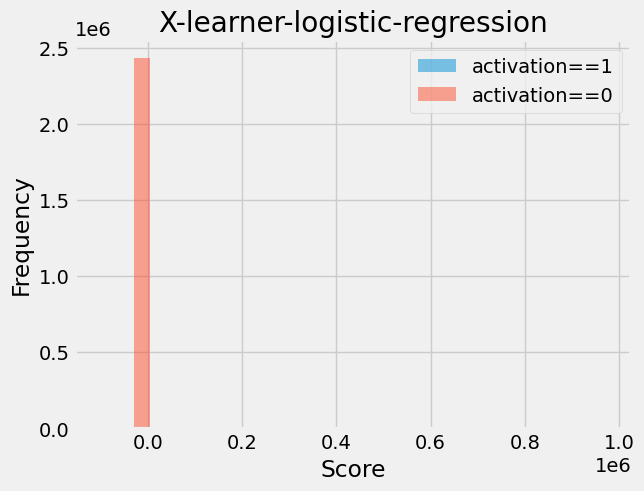

original input_df:
           customer  ind_recommended  activation  predicted_score
4301568     105799                0           0     -2385.326544
1433610     330393                0           0      -512.001362
11927286    209653                0           0      -404.599549
4141092     265761                0           0       -56.203842
4814215      59209                0           0      -779.457197
...            ...              ...         ...              ...
7355288     130303                0           0        -0.436063
8177944     335698                0           0      -167.152581
3251745     301963                0           0      -345.266570
941678      367640                0           0      -152.291056
2368599      23976                0           0      -182.778161

[2445996 rows x 4 columns]
After numerical:
           customer  ind_recommended  activation  predicted_score
4301568     105799                0           0     -2385.326544
1433610     330393      

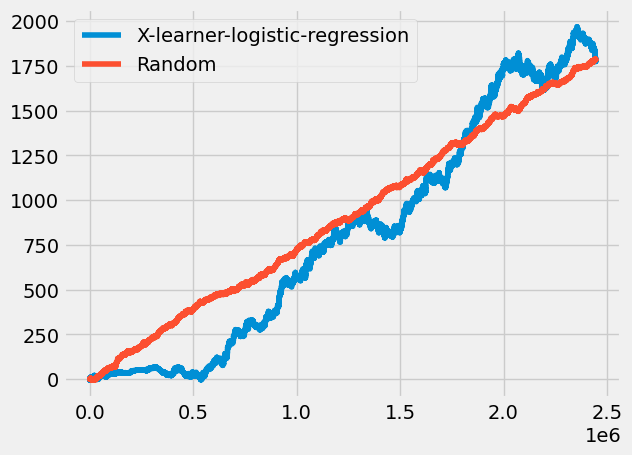

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
x_learner_lr = BaseXClassifier(outcome_learner=LogisticRegression(random_state=seed), effect_learner=LinearRegression())

x_learner_lr.fit(
    
    train_total.drop(columns=['activation','ind_recommended'],axis=1,inplace=False).values,
    treatment=train_total['ind_recommended'].values,
    y = train_total['activation'].values 
)

draw(validation_set,x_learner_lr,'X-learner-logistic-regression')

head
          X-learner-random-forest    w    y
887319             471609.622284  1.0  0.0
2051898            467935.549933  1.0  0.0
378488             465992.701456  1.0  0.0
1314668            382716.496211  0.0  0.0
1966328            366086.702467  1.0  0.0
117906             284919.109626  1.0  0.0
604857             171607.100691  0.0  0.0
1978983            168214.003912  0.0  0.0
448813             167827.300689  0.0  0.0
305462             163689.713151  1.0  0.0
106215             162061.539289  0.0  0.0
1385462            158086.568327  0.0  0.0
1720402            157811.810178  1.0  0.0
441159             155005.455127  0.0  0.0
2148034            152327.384644  0.0  0.0
Auuc
 X-learner-random-forest    0.436279
Random                     0.509874
dtype: float64


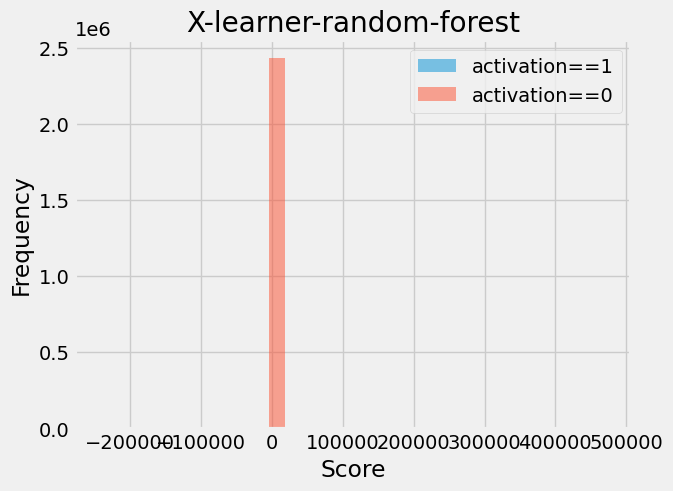

original input_df:
           customer  ind_recommended  activation  predicted_score
4301568     105799                0           0     -1970.668129
1433610     330393                0           0      -418.601540
11927286    209653                0           0      -342.031666
4141092     265761                0           0       -45.011812
4814215      59209                0           0      -661.737330
...            ...              ...         ...              ...
7355288     130303                0           0        -0.438366
8177944     335698                0           0      -140.278852
3251745     301963                0           0      -292.047983
941678      367640                0           0      -128.709918
2368599      23976                0           0      -149.819547

[2445996 rows x 4 columns]
After numerical:
           customer  ind_recommended  activation  predicted_score
4301568     105799                0           0     -1970.668129
1433610     330393      

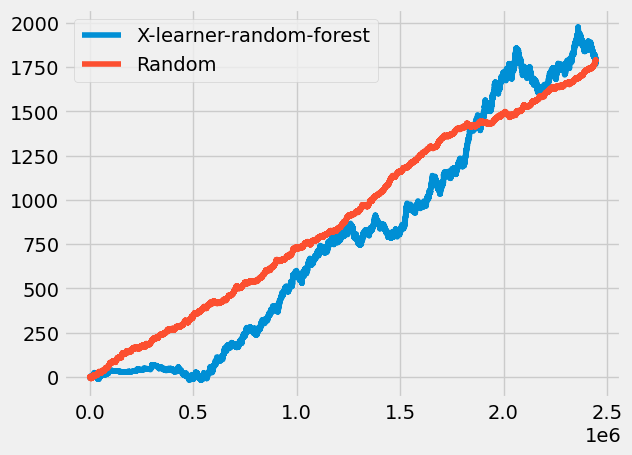

In [114]:
draw(validation_set,x_learner,'X-learner-random-forest')

In [19]:
incr_act

0.0007513835764103747

head
          X-learner-xgboost    w    y
1816729           1.699752  0.0  0.0
116107            1.569441  0.0  0.0
1183014           1.339001  0.0  1.0
1262051           1.328672  0.0  0.0
1531702           1.320782  0.0  1.0
693671            1.316256  0.0  0.0
2250523           1.316211  0.0  1.0
547648            1.309183  0.0  0.0
1039932           1.305162  0.0  0.0
1011202           1.302256  0.0  1.0
139761            1.301039  0.0  0.0
1166149           1.297403  0.0  0.0
2248719           1.296447  0.0  0.0
38983             1.296276  0.0  1.0
2041254           1.294600  1.0  0.0
Auuc
 X-learner-xgboost    0.676101
Random               0.509874
dtype: float64


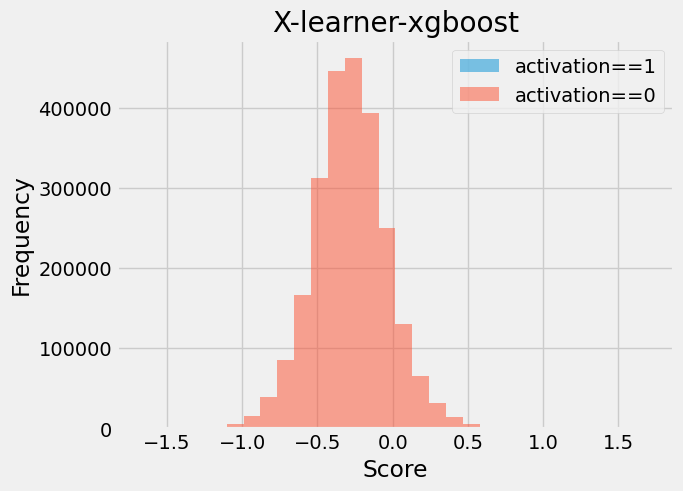

original input_df:
           customer  ind_recommended  activation  predicted_score
4301568     105799                0           0        -0.532286
1433610     330393                0           0        -0.423565
11927286    209653                0           0        -0.319451
4141092     265761                0           0         0.215868
4814215      59209                0           0        -0.542526
...            ...              ...         ...              ...
7355288     130303                0           0         0.008343
8177944     335698                0           0        -0.132732
3251745     301963                0           0        -0.046367
941678      367640                0           0        -0.106287
2368599      23976                0           0        -0.387166

[2445996 rows x 4 columns]
After numerical:
           customer  ind_recommended  activation  predicted_score
4301568     105799                0           0        -0.532286
1433610     330393      

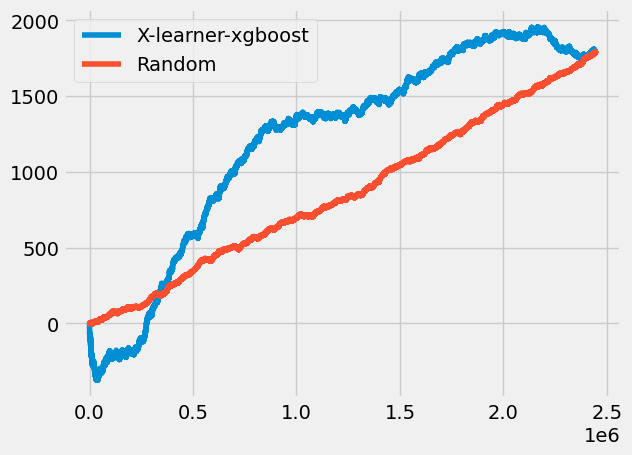

In [10]:
x_learner_xg = BaseXClassifier(outcome_learner=XGBClassifier(n_estimators=100,random_state=seed), effect_learner=XGBRegressor(n_estimators=100,random_state=seed))

x_learner_xg.fit(
    
    train_total.drop(columns=['activation','ind_recommended'],axis=1,inplace=False).values,
    treatment=train_total['ind_recommended'].values,
    y = train_total['activation'].values 
)
draw(validation_set,x_learner_xg,'X-learner-xgboost')

head
          X-learner-xgboost    w    y
701600            1.479533  0.0  0.0
366795            1.405906  0.0  0.0
846325            1.312795  0.0  0.0
596566            1.245054  1.0  0.0
1760820           1.133305  0.0  0.0
1055149           1.130467  0.0  0.0
1530829           1.110029  0.0  0.0
2441759           1.095269  0.0  0.0
1265385           1.085220  0.0  0.0
458945            1.081477  0.0  0.0
2393633           1.081344  0.0  0.0
211650            1.077884  1.0  0.0
1718158           1.063397  0.0  0.0
2067993           1.061954  0.0  0.0
2202154           1.060552  0.0  1.0
Auuc
 X-learner-xgboost    0.546027
Random               0.509874
dtype: float64


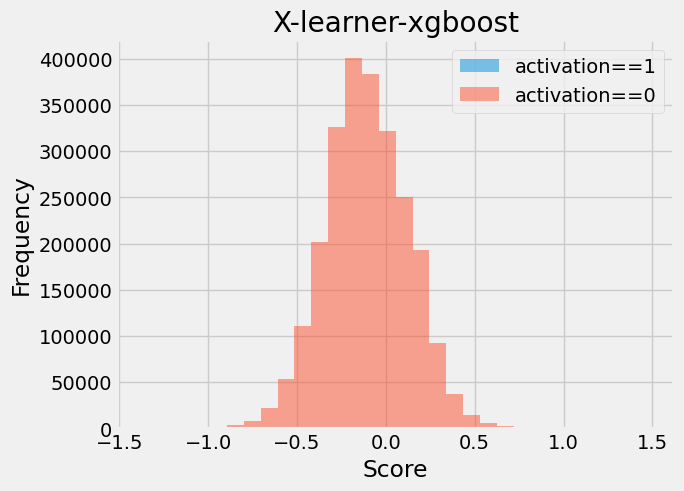

original input_df:
           customer  ind_recommended  activation  predicted_score
4301568     105799                0           0        -0.250576
1433610     330393                0           0        -0.196622
11927286    209653                0           0        -0.398549
4141092     265761                0           0         0.131196
4814215      59209                0           0        -0.424148
...            ...              ...         ...              ...
7355288     130303                0           0        -0.078871
8177944     335698                0           0         0.028350
3251745     301963                0           0        -0.053556
941678      367640                0           0         0.160561
2368599      23976                0           0        -0.154914

[2445996 rows x 4 columns]
After numerical:
           customer  ind_recommended  activation  predicted_score
4301568     105799                0           0        -0.250576
1433610     330393      

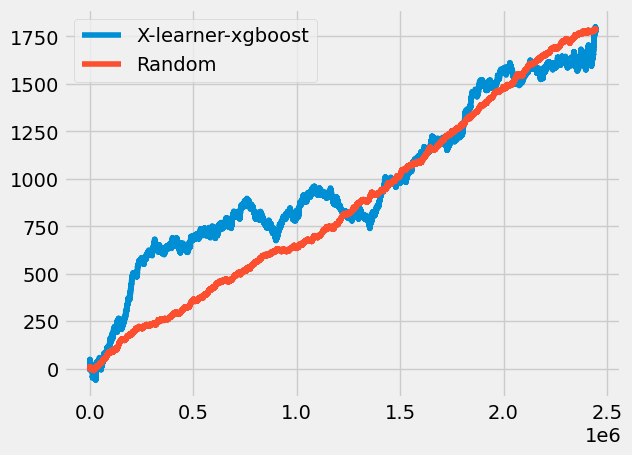

In [116]:
x_learner_xg = BaseXClassifier(outcome_learner=XGBClassifier(n_estimators=100,random_state=seed), effect_learner=XGBRegressor(n_estimators=100,random_state=seed))

x_learner_xg.fit(
    
    train_total.drop(columns=['activation','ind_recommended'],axis=1,inplace=False).values,
    treatment=train_total['ind_recommended'].values,
    y = train_total['activation'].values 
)
draw(validation_set,x_learner_xg,'X-learner-xgboost')

In [12]:
r_learner = BaseRClassifier(outcome_learner = LGBMClassifier(), effect_learner=LGBMRegressor())
r_learner.fit(
    
    train_total.drop(columns=['activation','ind_recommended'],axis=1,inplace=False).values,
    treatment=train_total['ind_recommended'].values,
    y = train_total['activation'].values 
)
draw(x_learner_lr,'R')

[LightGBM] [Info] Number of positive: 48056, number of negative: 47944
[LightGBM] [Info] Number of positive: 48045, number of negative: 47955
[LightGBM] [Info] Number of positive: 47880, number of negative: 48120
[LightGBM] [Info] Number of positive: 47982, number of negative: 48018
[LightGBM] [Info] Number of positive: 48037, number of negative: 47963
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013432 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 17030
[LightGBM] [Info] Number of data points in the train set: 96000, number of used features: 67
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500583 -> initscore=0.002333
[LightGBM] [Info] Start training from score 0.002333
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020548 seconds.
You can set `force_row_wise=true` to remove the overhea

: 

In [ ]:
# 给我画